In [ ]:
from clickhouse_driver import Client
import pandas as pd
from time import sleep

In [ ]:
import sys
import os

sys.path.append(os.path.join('./rank'))

In [ ]:
from rank.common.adjacency_list_to_graph import build_graph
from rank.common.calculate_spring_rank import calculate_spring_rank
from rank.common.graph_to_matrix import build_matrix

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot


In [ ]:
from pyquery import PyQuery as pq

In [ ]:
from sklearn.neighbors.kde import KernelDensity
from scipy.interpolate import interp1d
import numpy as np

In [ ]:
init_notebook_mode()

In [ ]:
import networkx as nx

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
client = Client('localhost', port=9001)

В статье:
- Описание предположений и текущей процедуры генезиса
  - Актуальность выбора адресов
  - Задача иерархического ранжирования
  - Spring Rank - назначение алгоритма
  - Предположения - близкие по рангу вершины имеют больший шанс наличия транзакции между ними
- Описание примера хорошего промо эйрдропа. 
  - Краткая статистика дропа (доля активных участников, количество распределенных токенов) - сделано
  - Связанный токен - сделано
  - Похожие токены - сделано
  - Ранги для похожего токена - сделано
  - Процесс отсечения адресов для похожего токена - сделано
- Описание того, как соотносятся результаты
  - Визуализация графа **распределения** с рангами в наибольшем похожем токене
  - Отсеченные вершины показаны серым 
  - Близкие по рангу вершины находятся ближе друг к другу
- Вывод
  - зависит ли активность от ранга в эфире? 
  - что еще нужно учесть

# Описание задачи

Количество участников сети и количество распределяемой между ними репутации - конечные значения, поэтому начальное распределение предполагало выбор адресов в сети Ethereum, которые, скорее всего, являются локальными "лидерами мнений". Так далее будем называть адреса, которые в плотно связанном подграфе (сообществе) связаны с наибольшим количеством вершин в нем.

Было предложено составлять этот список на основе меры центральности вершин графа транзакций. В качестве алгоритма ранжирования было решено использовать SpringRank. Этот алгоритм предполагает нахождение рангов через минимизацию энергии системы пружин с коэффициентами упругости, пропорциональными разности рангов связываемых вершин. Описанная в статье об этом алгоритме генеративная модель позволяет использовать значения рангов для вычисления количества и направления дуг между вершинами по формулам:

$$E_{ij} = c \exp{-\frac{\beta}{2}(s_i - s_j - 1)^2}$$

$$p_{ij} = \frac{1}{1 + \exp-2\beta(s_i - s_j)}$$

Т.е. количество дуг между вершинами $E_{ij}$ увеличивается при уменьшении разницы их рангов, а количество дуг от вершины с меньшим рангом меньше, чем количество дуг в обратном направлении (эти значения равны соответственно $E_{ij}p_{ij}$ и $E_{ij}(1 - p_{ij})$)

Этими свойствами можно воспользоваться при составлении списка для начального распределения. Действительно, предполагаемые "лидеры мнений" по условию имеют максимальное количество дуг в некотором подграфе, а это значило бы наличие у соотвествующих им вершин близких рангов. Первое решение, которое приходит в голову - провести оценку плотности рангов, выделить участки максимальной плотности (кластеры) и в итоговый список помещать адреса из каждого кластера, имеющие максимальную плотность в окрестности соответствующего им ранга.

# Демонстрация работы

Работает ли такой способ выбора лидеров мнений на самом деле? Сопоставим адреса, выбранные описанным выше способом, с адресами, активными во время одного из последних больших распределений ERC-20 токена в сети Ethereum - эйрдропа промо-токена проекта HEAL (HEALP)

Эйрдроп HEALP был проведен среди 1.3M участников, менее 1000 из них использовали его для получения основного токена проекта HEAL. Промо-токен получали все адреса, которые имели на балансе более 0.1 ETH. 

Лидеров мнений будем искать в графе транзакций проектов, похожих на HEAL. Можно увидеть, что владельцы этого токена отправляли хотя бы одну транзакцию следующих ERC-20 токенов: 

In [ ]:
MAIN_TOKEN_ADDRESS = "0xf6fd82dedbbe0ffadb5e1ecc2a283ab52b9ed2b0"
PROMO_TOKEN_ADDRESS = "0x7b2f9706cd8473b4f5b7758b0171a9933fc6c4d6"

In [ ]:
similar_tokens = client.execute("""
    SELECT token, holders, transactions FROM (
        SELECT token, count(distinct(from)) AS holders
        FROM ethereum_token_transaction_mv
        WHERE from in(
            SELECT from 
            FROM ethereum_token_transaction_mv
            WHERE token = '{}'
        )
        GROUP BY token
    )
    ANY INNER JOIN (
        SELECT token, count(*) AS transactions
        FROM ethereum_token_transaction_mv
        GROUP BY token
    )
    USING token
    ORDER BY holders DESC
""".format(MAIN_TOKEN_ADDRESS))

In [ ]:
similar_tokens_df = pd.DataFrame(similar_tokens, columns=["token", "holders", "transactions"])

In [ ]:
most_similar_tokens_df = similar_tokens_df.sort_values(["holders", "transactions"], ascending=[0, 0]).head()

In [ ]:
most_similar_tokens = [token for token in most_similar_tokens_df["token"].tolist() if token not in [MAIN_TOKEN_ADDRESS, PROMO_TOKEN_ADDRESS]]

In [ ]:
most_similar_token_string = ",".join(["'{}'".format(token) for token in most_similar_tokens])

In [95]:
most_similar_tokens_df.set_index("token")

,holders,transactions
token,,
0xf6fd82dedbbe0ffadb5e1ecc2a283ab52b9ed2b0,158,1857
0x358d12436080a01a16f711014610f8a4c2c2d233,36,167067
0x80bc5512561c7f85a3a9508c7df7901b370fa1df,32,63171
0x46b9ad944d1059450da1163511069c718f699d31,31,132022
0x4ceda7906a5ed2179785cd3a40a69ee8bc99c466,29,163121


## Ранжирование вершин
Ранжировать вершины будем в графе всех транзакций токенов, похожих на HEAL. Для того, чтобы избежать влияния выбросов на дальнейший анализ, сузим границы диапазона значений до квантилей уровня 0.01% и 99.99%

In [ ]:
similar_transactions = client.execute("""
    SELECT from, to
    FROM ethereum_token_transaction_mv
    WHERE 
        token in({})
        AND 
        from != '0x0000000000000000000000000000000000000000'
""".format(most_similar_token_string))

In [ ]:
similar_transactions_df = pd.DataFrame(similar_transactions, columns=["from", "to"]).groupby(["from", "to"]).size().reset_index()

In [ ]:
graph = nx.DiGraph()
graph.add_weighted_edges_from(similar_transactions_df.values)
nodes = list(graph.nodes)

In [ ]:
A = build_matrix(graph, nodes)

In [ ]:
iterations, raw_rank = calculate_spring_rank(A)
rank_df = pd.DataFrame(list(zip(nodes, raw_rank)), columns=["address", "rank"]).set_index("address").loc[nodes]

In [ ]:
rank_min = rank_df["rank"].quantile(0.001)
rank_max = rank_df["rank"].quantile(0.999)
ranks = ((rank_df["rank"] - rank_min) / (rank_max - rank_min) * 100).apply(lambda x: min(max(x, 0), 100))

# Кластеризация и отсечение адресов
После подсчета рангов с помощью SpringRank необходимо найти кластеры. Для этих целей в случае небольшого количества рангов можно воспользоваться алгоритмом MeanShift, который хорошо подходит для кластеризации одномерных данных при отсутствии фиксированного количества кластеров. Однако в графе транзакций Ethereum находится ~ 40M адресов, и цифра настолько велика для временной сложности этого алгоритма (которая оценивается как $O(n^2)$ при ограничении числа итераций, где $n$ - количество точек), что сильно увеличивает количество выпитых чашек кофе между запуском и получением результата.

Вместо MeanShift был предложен способ нахождения локальных экстремумов, который подразумевал простой поиск минимальных и максимальных значений в пределах некоторого скользящего окна для значений оценки плотности. Кластером в этом случае можно считать отрезок между двумя локальными минимумами, содержащий локальный максимум. Существуют реализации используемого в этом случае алгоритм оценки плотности KDE с временной сложностью $O(n)$, что применимо в данном случае

Важно отметить, что перед поиском экстремумов необходимо линейно интерполировать значения KDE с фиксированным шагом сетки, поскольку в исходной оценке плотности в окрестности локального максимума лежит гораздо большее количество точек, нежели в окрестности локального минимума, что делает затруднительным выбор размера скользящего окна.

In [ ]:
def find_name(address, error=0):
    if error > 5:
        return ""
    try:
        document = pq("https://etherscan.io/address/{}".format(address))
        error_string = document("#ContentPlaceHolder1_lblAdResult + br + br + font").text()
        if "Sorry, You have reached your maximum request limit for this resource" in error_string:
            print("Error occured!")
            sleep(5)
            return find_name(address, error + 1)
        else:
            name = document("[title=NameTag]").text()
            return name
    except KeyboardInterrupt as e:
        print("Interrupted")
        raise e
    except Exception as e:
        print(address)
        sleep(5)
        return find_name(address, error + 1)

In [ ]:
nodes_df = ranks.to_frame()

In [ ]:
nodes_df.loc[[a for a, _ in graph.degree], "degree"] = [b for _, b in graph.degree]

In [ ]:
big_nodes = nodes_df[nodes_df["degree"] > 10]
nodes_df["name"] = ""
nodes_df.loc[big_nodes.index, "name"] = [find_name(address) for address in tqdm_notebook(big_nodes.index)]

In [ ]:
kde = KernelDensity()
X = ranks.values.reshape(-1, 1)
kde.fit(X)
kde_out = np.exp(kde.score_samples(X))

In [ ]:
kde_interpolation = interp1d(X.reshape(-1), kde_out)
grid = np.linspace(ranks.min(), ranks.max(), ranks.shape[0] * 10)
kde_values = kde_interpolation(grid)

In [ ]:
WINDOW_SIZE = 20

kde_values_df = pd.DataFrame({"rank": grid, "kde": kde_values}).set_index("rank")
kde_values_df["min"] = kde_values_df["kde"].rolling(WINDOW_SIZE, center=True).min().fillna(kde_values_df["kde"][0:WINDOW_SIZE].min())
kde_values_df["max"] = kde_values_df["kde"].rolling(WINDOW_SIZE, center=True).max().fillna(kde_values_df["kde"][0:WINDOW_SIZE].max())
kde_values_df["is_min"] = kde_values_df["kde"] == kde_values_df["min"]
kde_values_df["is_max"] = kde_values_df["kde"] == kde_values_df["max"]

In [ ]:
cluster_starts = []
was_max = False
for rank, row in kde_values_df.iterrows():
    if row["is_min"] and was_max:
        cluster_starts.append(rank)
        was_max = False
    if row["is_max"]:
        was_max = True

In [ ]:
clusters = []
nodes_df["cluster"] = nodes_df["rank"].apply(lambda x: len([c for c in cluster_starts if c < x]))
nodes_df["kde"] = kde_out[np.argsort(nodes_df["rank"].tolist())]

In [ ]:
nodes_df.shape

In [ ]:
chosen_addresses = []
CHOSEN_ADDRESSES = 1000
for cluster in nodes_df["cluster"].unique():
    cluster_nodes = nodes_df[nodes_df["cluster"] == cluster].sort_values("kde", ascending=False)
    cluster_pie = cluster_nodes.shape[0] / nodes_df.shape[0]
    chosen_size = max(int(CHOSEN_ADDRESSES*cluster_pie), 1)
    chosen_addresses += cluster_nodes.iloc[:chosen_size].index.tolist()

In [ ]:
kde_values_df.to_csv("kde_values.csv")

In [ ]:
nodes_df.to_csv("nodes.csv")

Ниже приведен интерполированный график плотности рангов с отмеченными на нем найденными локальными экстремумами (максимумы - зеленый, минимумы - оранжевый). Отдельно отмечены ранги крупных адресов, которые могут пользоваться популярностью в том числе у владельцев токенов проектов, похожих на HEAL. Можно заметить, что многие из них находятся возле локальных максимумов.

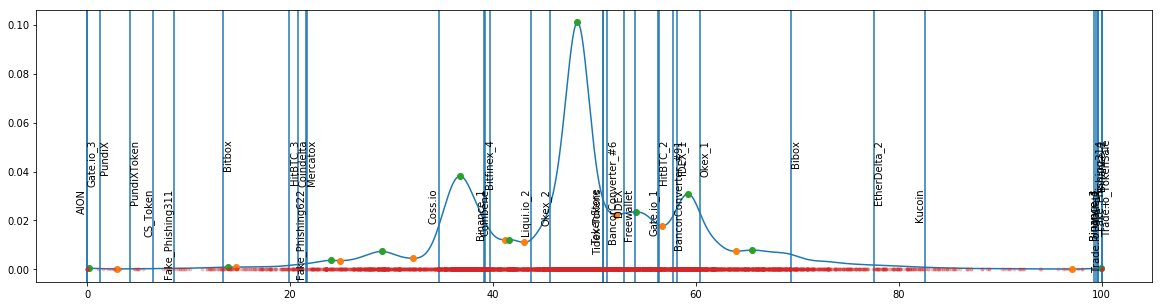

In [94]:
plt.figure(figsize=(20, 5))
plt.plot(kde_values_df.index, kde_values_df.kde)
minimas = kde_values_df[kde_values_df["is_min"]]
plt.plot(minimas.index, minimas.kde, "o")
maximas = kde_values_df[kde_values_df["is_max"]]
plt.plot(maximas.index, maximas.kde, "o")
index = 0
for address, node in tqdm_notebook(nodes_df[nodes_df["name"] != ""].iterrows(), total=nodes_df[nodes_df["name"] != ""].shape[0]):
    plt.axvline(node["rank"])
    plt.text(node["rank"] - (1 - index % 2)*1, (index % 2) * 0.02 + 0.03, node["name"],rotation=90)
    index += 1
plt.plot(nodes_df.loc[chosen_addresses]["rank"], [0] * len(chosen_addresses), ".", alpha=0.2)

# Связь рангов и активности (TBD)
Проверить, насколько активны были "лидеры мнений" похожих на HEAL проектов во время раздачи токена можно при сопоставлении адресов участников эйрдропа с их рангами. Граф участников и связей между ними представлен ниже. 

Можно видеть, что (составить визуализацию и уточнить). То есть, если бы HEALP раздавался бы только тысяче "лидеров мнений", среди участников было бы ...  активных.

In [ ]:
transactions = client.execute("""
    SELECT from, to
    FROM ethereum_token_transaction_mv
    WHERE 
        token = '{}'
""".format(PROMO_TOKEN_ADDRESS))

In [ ]:
transactions_df = pd.DataFrame(transactions, columns=["from", "to"]).groupby(["from", "to"]).size().reset_index()

In [ ]:
addresses_df = transactions_df.groupby("from")["to"].nunique()
addresses = addresses_df[addresses_df > 1].index
addresses = [a for a in addresses if a in nodes_df.index]
len(addresses)

In [ ]:
filtered_transactions_df = transactions_df[transactions_df["from"].isin(addresses) & transactions_df["to"].isin(addresses)].copy()

In [ ]:
filtered_transactions_df = transactions_df[transactions_df["from"].isin(addresses) & transactions_df["to"].isin(addresses)].copy()

In [ ]:
filtered_transactions_df.shape[0]

In [ ]:
filtered_transactions_df["from_rank"] = nodes_df.loc[filtered_transactions_df["from"]]["rank"].tolist()
filtered_transactions_df["to_rank"] = nodes_df.loc[filtered_transactions_df["from"]]["rank"].tolist()
filtered_transactions_df["weight"] = 1 / ((filtered_transactions_df["from_rank"] - filtered_transactions_df["to_rank"]) - 1) ** 2

In [ ]:
graph = nx.DiGraph()
graph.add_weighted_edges_from(filtered_transactions_df[["from", "to", "weight"]].values)
nodes = list(graph.nodes)

In [ ]:
pos = nx.spring_layout(graph)
for n, (x, y) in tqdm_notebook(pos.items()):
    graph.node[n]['pos'] = (x, y)

In [ ]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in tqdm_notebook(graph.edges()):
    x0, y0 = graph.node[edge[0]]['pos']
    x1, y1 = graph.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [ ]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Rainbow',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Rank',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in tqdm_notebook(graph.nodes()):
    x, y = graph.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [ ]:
node_trace['marker']['color'] = nodes_df["rank"].loc[list(graph.nodes())].tolist()
# node_trace["marker"]['size'] = nodes_df["name"].apply(get_size)
node_trace['text'] = nodes_df["name"]

In [ ]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Ranks',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx')

# Вывод (TBD)

...

Важно отметить, что в силу использования принципа максимального правдоподобия, результаты работы SpringRank без применения регуляризации могут оказаться статистически незначимыми для определенных графов. На данный момент вопрос оценки статистической значимости полученных рангов выносится за пределы этой статьи